# GROBID Pipeline Optimization Notebook với Tự Động Điều Chỉnh

## Tối ưu hóa Pipeline xử lý GROBID với cơ chế tự cân bằng tải

Notebook này trình bày phiên bản tối ưu của pipeline trích xuất dữ liệu từ PDF khoa học bằng GROBID API. Các cải tiến chính bao gồm:

1. **Xử lý song song**: Tăng hiệu suất xử lý bằng cách sử dụng nhiều worker cùng lúc
2. **Checkpoint và phục hồi**: Lưu trạng thái xử lý, có thể tạm dừng và tiếp tục ở bài báo đã dừng
3. **Kiểm soát tốc độ truy cập (Rate limiting)**: Giới hạn số lượng yêu cầu đến GROBID server để tránh quá tải
4. **Cơ chế thử lại thông minh**: Xử lý lỗi và thử lại với độ trễ tăng dần (exponential backoff)
5. **Ghi log chi tiết**: Theo dõi quá trình xử lý và phân tích hiệu suất
6. **Tự động điều chỉnh (Auto-tuning)**: Tự động tìm điểm cân bằng giữa hiệu suất và tải server

### Cơ chế Tự Động Điều Chỉnh

Tính năng mới này giúp pipeline tự động điều chỉnh thông số hoạt động dựa trên phản hồi của GROBID server:

- **Giám sát hiệu suất thời gian thực**: Theo dõi thời gian phản hồi và tỷ lệ lỗi
- **Điều chỉnh số lượng worker**: Tăng/giảm song song dựa trên hiệu suất server
- **Điều chỉnh tốc độ truy cập**: Tăng/giảm số lượng request mỗi phút
- **Bảo vệ server tự động**: Giảm tải khi phát hiện dấu hiệu quá tải
- **Tối đa hóa thông lượng**: Tăng tải khi server đáp ứng tốt

## Hướng dẫn sử dụng

1. **Cài đặt thư viện cần thiết**:
   ```bash
   pip install pandas requests lxml tqdm requests-toolbelt matplotlib
   ```

2. **Cấu hình tự động điều chỉnh**:
   - `AUTO_TUNE = True/False`: Bật/tắt tính năng tự động điều chỉnh
   - `TUNE_INTERVAL`: Số lượng bài báo xử lý trước khi điều chỉnh
   - `MAX_WORKERS_LIMIT`: Giới hạn số lượng worker tối đa
   - `MAX_REQUESTS_PER_MINUTE`: Giới hạn tốc độ truy cập tối đa

3. **Chạy pipeline**:
   ```python
   # Tải dữ liệu
   df_papers = load_papers_data()
   
   # Chạy pipeline tối ưu
   run_optimized_pipeline(df_papers)
   ```

4. **Theo dõi và phân tích kết quả**:
   - Pipeline tự động hiển thị thống kê trong quá trình chạy
   - Sử dụng `visualize_performance_stats()` để tạo biểu đồ hiệu suất
   - Nhật ký chi tiết được lưu trong file CSV

5. **Tạm dừng và tiếp tục**:
   - Bạn có thể tạm dừng quá trình xử lý bằng cách nhấn Ctrl+C
   - Khi chạy lại, pipeline sẽ tiếp tục từ bài báo cuối cùng chưa được xử lý
   
6. **Điều chỉnh thủ công**:
   - Nếu thấy server quá tải: Giảm `MAX_WORKERS` và `REQUESTS_PER_MINUTE`
   - Nếu thấy hiệu suất thấp: Tăng `MAX_WORKERS` và `REQUESTS_PER_MINUTE`
   - Hoặc để `AUTO_TUNE = True` và pipeline sẽ tự động tìm điểm cân bằng

In [3]:
import json
import logging
import io
import os
import time
import concurrent.futures
import random
import pickle
from pathlib import Path
from typing import List, Dict, Optional, Tuple, Any, Union, Set
from datetime import datetime, timezone
import threading
import queue

# Third-party libraries
import pandas as pd
import requests
import numpy as np
from lxml import etree
from tqdm.notebook import tqdm
from requests_toolbelt.multipart.encoder import MultipartEncoder
from lxml.etree import _Element as etree_element

# Đảm bảo thư viện requests-toolbelt được cài đặt
try:
    from requests_toolbelt.multipart.encoder import MultipartEncoder
except ImportError:
    import sys
    !{sys.executable} -m poetry add requests-toolbelt
    from requests_toolbelt.multipart.encoder import MultipartEncoder

In [16]:
# Configure basic logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# --- CẤU HÌNH PIPELINE ---
# Đường dẫn input và output
INPUT_DIR = Path("./processed_data")
OUTPUT_DIR = Path("./grobid_pipeline_output")
SUCCESS_OUTPUT_PATH = OUTPUT_DIR / "successful_papers.jsonl"
PROCESSING_LOG_PATH = OUTPUT_DIR / "processing_journal.csv"
CHECKPOINT_PATH = OUTPUT_DIR / "processing_checkpoint.pkl"

# Cấu hình bắt đầu từ paper cụ thể
START_FROM_PAPER_ID = None  # Bắt đầu từ paper_id cụ thể, nếu None sẽ dùng START_FROM_PAPER_INDEX
START_FROM_PAPER_INDEX = 348  # Bắt đầu từ paper thứ 301 (index từ 0) nếu START_FROM_PAPER_ID là None
SKIP_PROCESSED_PAPERS = True  # Bỏ qua các paper đã xử lý

# Tạo thư mục output nếu chưa tồn tại
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# --- Cấu hình GROBID Server ---
GROBID_SERVER_URL = "http://206.189.83.120:8070"
API_HEADER_URL = f"{GROBID_SERVER_URL}/api/processHeaderDocument"
API_REFERENCES_URL = f"{GROBID_SERVER_URL}/api/processReferences"
API_FULLTEXT_URL = f"{GROBID_SERVER_URL}/api/processFulltextDocument"

# Định nghĩa TEI namespace cho XPath
NS = {'tei': 'http://www.tei-c.org/ns/1.0'}

# --- CẤU HÌNH NÂNG CAO ---
# Số lượng worker tối đa và tối thiểu cho xử lý song song 
MAX_WORKERS_LIMIT = 4  # Giới hạn tối đa
MIN_WORKERS = 2        # Giới hạn tối thiểu
INITIAL_WORKERS = 3    # Số lượng worker ban đầu
MAX_WORKERS = INITIAL_WORKERS  # Biến sẽ được điều chỉnh tự động

# Thông số giới hạn tốc độ truy cập
MAX_REQUESTS_PER_MINUTE = 30  # Giới hạn tối đa
MIN_REQUESTS_PER_MINUTE = 10  # Giới hạn tối thiểu
INITIAL_REQUESTS_PER_MINUTE = 20  # Tốc độ ban đầu
REQUESTS_PER_MINUTE = INITIAL_REQUESTS_PER_MINUTE  # Biến sẽ được điều chỉnh tự động
MIN_REQUEST_INTERVAL = 60 / REQUESTS_PER_MINUTE  # Thời gian tối thiểu giữa các request

# Cấu hình thử lại
MAX_RETRIES = 3  # Số lần thử lại tối đa
RETRY_DELAY = 5  # Thời gian chờ ban đầu (giây)
RETRY_BACKOFF_FACTOR = 2  # Hệ số tăng thời gian chờ

# Kích thước batch cho lưu checkpoint
CHECKPOINT_BATCH_SIZE = 10  # Lưu checkpoint sau mỗi 10 bài báo

# --- CẤU HÌNH TỰ ĐỘNG ĐIỀU CHỈNH ---
AUTO_TUNE = True  # Bật/tắt tính năng tự động điều chỉnh
TUNE_INTERVAL = 20  # Số lượng bài báo xử lý trước khi điều chỉnh
# Ngưỡng thời gian phản hồi (ms)
RESPONSE_TIME_THRESHOLD_GOOD = 5000  # Dưới 5s: hiệu suất tốt, có thể tăng tốc
RESPONSE_TIME_THRESHOLD_BAD = 15000  # Trên 15s: hiệu suất kém, cần giảm tốc
# Ngưỡng tỷ lệ lỗi
ERROR_RATE_THRESHOLD = 0.1  # 10% tỷ lệ lỗi là ngưỡng để giảm tốc
# Hệ số điều chỉnh
SCALE_UP_FACTOR = 1.2  # Tăng 20% khi hiệu suất tốt
SCALE_DOWN_FACTOR = 0.8  # Giảm 20% khi hiệu suất kém

## Các lớp và hàm tiện ích

In [17]:
def check_grobid_status():
    """
    Kiểm tra trạng thái của GROBID server.
    
    Returns:
        bool: True nếu server đang hoạt động, False nếu không
    """
    try:
        response = requests.get(f"{GROBID_SERVER_URL}/api/isalive", timeout=5)
        return response.status_code == 200
    except:
        return False

class RateLimiter:
    """
    Bộ kiểm soát tốc độ truy cập thread-safe để tránh quá tải GROBID server.
    Hỗ trợ điều chỉnh tốc độ truy cập động.
    """
    def __init__(self, requests_per_minute):
        self.requests_per_minute = requests_per_minute
        self.interval = 60.0 / requests_per_minute
        self.last_request_time = 0
        self.lock = threading.Lock()
        # Thêm biến theo dõi hiệu suất
        self.response_times = []
        self.error_count = 0
        self.request_count = 0
        
    def update_rate(self, new_rate):
        """Cập nhật tốc độ truy cập"""
        with self.lock:
            self.requests_per_minute = new_rate
            self.interval = 60.0 / new_rate
            logger.info(f"Cập nhật tốc độ truy cập: {new_rate} request/phút")
        
    def wait(self):
        """Chờ nếu cần thiết để duy trì giới hạn tốc độ"""
        with self.lock:
            current_time = time.time()
            time_since_last_request = current_time - self.last_request_time
            
            if time_since_last_request < self.interval:
                sleep_time = self.interval - time_since_last_request
                time.sleep(sleep_time)
                
            self.last_request_time = time.time()
    
    def record_response_time(self, response_time_ms):
        """Ghi lại thời gian phản hồi"""
        with self.lock:
            self.response_times.append(response_time_ms)
            self.request_count += 1
            # Chỉ giữ 100 giá trị gần nhất
            if len(self.response_times) > 100:
                self.response_times.pop(0)
    
    def record_error(self):
        """Ghi lại lỗi"""
        with self.lock:
            self.error_count += 1
            self.request_count += 1
    
    def get_stats(self):
        """Lấy thống kê hiệu suất hiện tại"""
        with self.lock:
            if not self.response_times:
                avg_response_time = 0
            else:
                avg_response_time = sum(self.response_times) / len(self.response_times)
            
            if self.request_count == 0:
                error_rate = 0
            else:
                error_rate = self.error_count / self.request_count
                
            # Reset bộ đếm sau khi lấy thống kê
            self.error_count = 0
            self.request_count = 0
            
            return {
                "avg_response_time_ms": avg_response_time,
                "error_rate": error_rate,
                "current_rate": self.requests_per_minute
            }

# Tạo bộ kiểm soát tốc độ truy cập toàn cục
rate_limiter = RateLimiter(REQUESTS_PER_MINUTE)

class PerformanceMonitor:
    """
    Lớp theo dõi hiệu suất và điều chỉnh tham số tự động.
    """
    def __init__(self, rate_limiter):
        self.rate_limiter = rate_limiter
        self.lock = threading.Lock()
        self.workers = MAX_WORKERS
        self.papers_processed = 0
        
    def update(self):
        """
        Cập nhật và điều chỉnh tham số dựa trên hiệu suất.
        Trả về số lượng worker mới.
        """
        global MAX_WORKERS
        
        if not AUTO_TUNE:
            return MAX_WORKERS
            
        with self.lock:
            self.papers_processed += 1
            
            # Chỉ điều chỉnh sau mỗi TUNE_INTERVAL bài báo
            if self.papers_processed % TUNE_INTERVAL != 0:
                return MAX_WORKERS
                
            # Lấy thống kê hiệu suất
            stats = self.rate_limiter.get_stats()
            avg_response_time = stats["avg_response_time_ms"]
            error_rate = stats["error_rate"]
            current_rate = stats["current_rate"]
            
            logger.info(f"Hiệu suất hiện tại: Thời gian phản hồi trung bình={avg_response_time:.2f}ms, "
                      f"Tỷ lệ lỗi={error_rate:.2%}, "
                      f"Tốc độ truy cập={current_rate} req/phút, "
                      f"Worker={MAX_WORKERS}")
            
            # Điều chỉnh dựa trên hiệu suất
            if avg_response_time < RESPONSE_TIME_THRESHOLD_GOOD and error_rate < ERROR_RATE_THRESHOLD:
                # Hiệu suất tốt - tăng tốc
                new_rate = min(int(current_rate * SCALE_UP_FACTOR), MAX_REQUESTS_PER_MINUTE)
                new_workers = min(int(MAX_WORKERS * SCALE_UP_FACTOR), MAX_WORKERS_LIMIT)
                
                if new_rate > current_rate or new_workers > MAX_WORKERS:
                    logger.info(f"Hiệu suất tốt - Tăng tốc: worker {MAX_WORKERS}->{new_workers}, "
                              f"rate {current_rate}->{new_rate}")
                    
                    # Cập nhật giá trị
                    self.rate_limiter.update_rate(new_rate)
                    MAX_WORKERS = new_workers
                
            elif avg_response_time > RESPONSE_TIME_THRESHOLD_BAD or error_rate >= ERROR_RATE_THRESHOLD:
                # Hiệu suất kém - giảm tốc
                new_rate = max(int(current_rate * SCALE_DOWN_FACTOR), MIN_REQUESTS_PER_MINUTE)
                new_workers = max(int(MAX_WORKERS * SCALE_DOWN_FACTOR), MIN_WORKERS)
                
                logger.info(f"Hiệu suất kém - Giảm tốc: worker {MAX_WORKERS}->{new_workers}, "
                          f"rate {current_rate}->{new_rate}")
                
                # Cập nhật giá trị
                self.rate_limiter.update_rate(new_rate)
                MAX_WORKERS = new_workers
            
            return MAX_WORKERS

# Tạo đối tượng theo dõi hiệu suất
performance_monitor = PerformanceMonitor(rate_limiter)

## Hàm gọi GROBID API với cơ chế thử lại

In [18]:
def get_grobid_xml_from_url(
    api_url: str, 
    pdf_url: str, 
    consolidate: bool = True, 
    include_raw: bool = True,
    retry_count: int = 0
) -> Optional[etree._Element]:
    """
    Tải PDF từ URL và gửi trực tiếp từ memory đến GROBID API.
    Sử dụng các phương pháp đã được tối ưu để tránh lỗi Java null pointer.
    
    Args:
        api_url: URL của GROBID API endpoint
        pdf_url: URL của file PDF cần xử lý
        consolidate: Bật tính năng 'consolidate' 
        include_raw: Bật tính năng 'include_raw'
        retry_count: Số lần thử lại hiện tại
        
    Returns:
        Optional[etree._Element]: Đối tượng XML đã được phân tích từ GROBID hoặc None nếu có lỗi
    """
    # Áp dụng giới hạn tốc độ truy cập
    rate_limiter.wait()
    
    try:
        logger.info(f"Đang tải PDF từ URL: {pdf_url}")
        start_time = time.time() * 1000  # Bắt đầu đo thời gian (ms)
        
        pdf_response = requests.get(pdf_url, timeout=20, allow_redirects=True)
        pdf_response.raise_for_status()
        
        pdf_content = pdf_response.content
        logger.info(f"Đã tải PDF thành công, kích thước: {len(pdf_content)} bytes")
        
        # Kiểm tra magic number của PDF
        if not pdf_content.startswith(b'%PDF'):
            logger.error("Error: Nội dung tải về không phải là file PDF hợp lệ!")
            rate_limiter.record_error()
            return None
        
        # Xác định các tham số phù hợp với API endpoint
        data = {}
        
        if "processHeaderDocument" in api_url:
            if consolidate:
                data["consolidateHeader"] = "1"
            if include_raw:
                data["includeRawAffiliations"] = "1"
        
        elif "processReferences" in api_url:
            if consolidate:
                data["consolidateCitations"] = "1"
            if include_raw:
                data["includeRawCitations"] = "1"
        
        logger.info(f"Gửi PDF đến GROBID API: {api_url}")
        
        # Phương pháp 1: Sử dụng BytesIO.getvalue() với tham số 'input'
        bytesio = io.BytesIO(pdf_content)
        files = {'input': ('input.pdf', bytesio.getvalue(), 'application/pdf')}
        headers = {'Accept': 'application/xml'}
        
        grobid_response = requests.post(
            api_url,
            files=files,
            headers=headers,
            data=data,
            timeout=30
        )
        
        # Tính thời gian phản hồi
        response_time = time.time() * 1000 - start_time
        logger.info(f"GROBID response status: {grobid_response.status_code}, time: {response_time:.2f}ms")
        
        if grobid_response.status_code == 200:
            # Ghi lại thời gian phản hồi thành công
            rate_limiter.record_response_time(response_time)
            logger.info("Phân tích XML từ response thành công")
            return etree.fromstring(grobid_response.content)
        else:
            logger.warning(f"GROBID trả về status {grobid_response.status_code}")
            rate_limiter.record_error()
            
            # Phương pháp 2: Thử với requests-toolbelt nếu phương pháp 1 thất bại
            try:
                logger.info("Thử phương pháp thay thế với requests-toolbelt...")
                
                start_time = time.time() * 1000  # Reset thời gian bắt đầu
                
                bytesio = io.BytesIO()
                bytesio.write(pdf_content)
                bytesio.seek(0)
                
                fields = {
                    **data,
                    'input': ('input.pdf', bytesio, 'application/pdf')
                }
                
                m = MultipartEncoder(fields=fields)
                
                headers = {
                    'Content-Type': m.content_type,
                    'Accept': 'application/xml'
                }
                
                grobid_response = requests.post(
                    api_url,
                    data=m,
                    headers=headers,
                    timeout=30
                )
                
                # Tính thời gian phản hồi cho phương pháp 2
                response_time = time.time() * 1000 - start_time
                logger.info(f"GROBID response status (phương pháp 2): {grobid_response.status_code}, time: {response_time:.2f}ms")
                
                if grobid_response.status_code == 200:
                    # Ghi lại thời gian phản hồi thành công
                    rate_limiter.record_response_time(response_time)
                    logger.info("Phân tích XML từ response thành công (phương pháp 2)")
                    return etree.fromstring(grobid_response.content)
                else:
                    rate_limiter.record_error()
                    # Xử lý thử lại
                    if retry_count < MAX_RETRIES:
                        retry_delay = RETRY_DELAY * (RETRY_BACKOFF_FACTOR ** retry_count)
                        logger.warning(f"Thử lại sau {retry_delay} giây (lần {retry_count+1}/{MAX_RETRIES})")
                        time.sleep(retry_delay)
                        return get_grobid_xml_from_url(api_url, pdf_url, consolidate, include_raw, retry_count + 1)
                    else:
                        logger.error(f"Đã đạt số lần thử lại tối đa cho {pdf_url}")
                        return None
            except Exception as e:
                logger.error(f"Lỗi với phương pháp 2: {str(e)}")
                rate_limiter.record_error()
            
    except requests.exceptions.RequestException as e:
        logger.error(f"Lỗi mạng khi xử lý URL {pdf_url}: {e}")
        rate_limiter.record_error()
        # Xử lý thử lại cho lỗi mạng
        if retry_count < MAX_RETRIES:
            retry_delay = RETRY_DELAY * (RETRY_BACKOFF_FACTOR ** retry_count)
            logger.warning(f"Thử lại sau {retry_delay} giây (lần {retry_count+1}/{MAX_RETRIES})")
            time.sleep(retry_delay)
            return get_grobid_xml_from_url(api_url, pdf_url, consolidate, include_raw, retry_count + 1)
    except Exception as e:
        logger.error(f"Lỗi không mong đợi: {e}")
        rate_limiter.record_error()
        import traceback
        logger.error(traceback.format_exc())
    
    return None

## Các hàm xử lý XML/TEI thành JSON

In [5]:
def parse_grobid_authors(xml_root: etree._Element) -> List[Dict[str, str]]:
    """
    Trích xuất danh sách tác giả từ XML header theo đúng logic mô hình dữ liệu.
    
    Args:
        xml_root: Đối tượng XML đã được phân tích từ GROBID header API
        
    Returns:
        List[Dict]: Danh sách các đối tượng tác giả với thông tin tương ứng
    """
    if xml_root is None:
        return []

    authors = []
    author_elements = xml_root.xpath('//tei:teiHeader/tei:fileDesc/tei:sourceDesc/tei:biblStruct/tei:analytic/tei:author', namespaces=NS)
    
    for i, author in enumerate(author_elements, 1):
        author_info = {}
        
        # Lấy tên đầy đủ
        persName = author.find('.//tei:persName', namespaces=NS)
        if persName is not None:
            forenames = persName.xpath('./tei:forename/text()', namespaces=NS)
            surname = persName.xpath('./tei:surname/text()', namespaces=NS)
            if forenames or surname:
                author_info["name"] = ' '.join(forenames + surname)
        
        # Trích xuất thông tin affiliation
        aff_elements = author.findall('.//tei:affiliation', namespaces=NS)
        
        if aff_elements:
            # Lấy thông tin từ affiliation đầu tiên
            aff_element = aff_elements[0]
            
            # Lấy raw_affiliation từ note type="raw_affiliation"
            raw_aff_nodes = aff_element.xpath('.//tei:note[@type="raw_affiliation"]', namespaces=NS)
            
            if raw_aff_nodes and len(raw_aff_nodes) > 0 and raw_aff_nodes[0].text:
                author_info["affiliation"] = raw_aff_nodes[0].text.strip()
            
            # Lấy tất cả các orgName để tăng tính tổng quát
            org_names = aff_element.findall('.//tei:orgName', namespaces=NS)
            if org_names:
                # Ưu tiên orgName đầu tiên cho parsed_affiliation
                if org_names[0] is not None and org_names[0].text:
                    author_info["parsed_affiliation"] = org_names[0].text.strip()

        # Chỉ thêm tác giả vào danh sách nếu có ít nhất tên
        if "name" in author_info:
            authors.append(author_info)
            
    return authors

In [6]:
def parse_grobid_references(xml_root: etree._Element) -> List[Dict[str, Any]]:
    """
    Trích xuất danh sách tài liệu tham khảo từ XML/TEI theo chuẩn NeurIPS.
    
    Args:
        xml_root: Đối tượng XML đã được phân tích từ GROBID references API
        
    Returns:
        List[Dict]: Danh sách các đối tượng tài liệu tham khảo với thông tin tương ứng
    """
    if xml_root is None:
        return []

    references = []
    bibl_structs = xml_root.xpath('//tei:listBibl/tei:biblStruct', namespaces=NS)
    for bibl in bibl_structs:
        # raw_text
        raw_note = bibl.xpath('./tei:note[@type="raw_reference"]/text()', namespaces=NS)
        raw_text = raw_note[0] if raw_note else None

        # title: ưu tiên analytic/title[level=a], nếu không có thì monogr/title[level=m]
        title = None
        analytic_title = bibl.xpath('./tei:analytic/tei:title[@level="a"]/text()', namespaces=NS)
        if analytic_title:
            title = analytic_title[0]
        else:
            monogr_title = bibl.xpath('./tei:monogr/tei:title[@level="m"]/text()', namespaces=NS)
            if monogr_title:
                title = monogr_title[0]

        # year
        year_nodes = bibl.xpath('./tei:monogr/tei:imprint/tei:date[@type="published"]/@when', namespaces=NS)
        year = year_nodes[0] if year_nodes else None

        # venue: ưu tiên title[level=m], nếu không có thì title[level=j]
        venue = None
        venue_m = bibl.xpath('./tei:monogr/tei:title[@level="m"]/text()', namespaces=NS)
        venue_j = bibl.xpath('./tei:monogr/tei:title[@level="j"]/text()', namespaces=NS)
        if venue_m:
            venue = venue_m[0]
        elif venue_j:
            venue = venue_j[0]

        # authors: analytic/author hoặc monogr/author
        authors = []
        author_elements = bibl.xpath('./tei:analytic/tei:author', namespaces=NS)
        if not author_elements:
            author_elements = bibl.xpath('./tei:monogr/tei:author', namespaces=NS)
        for author in author_elements:
            pers_name = author.find('tei:persName', namespaces=NS)
            if pers_name is not None:
                forenames = pers_name.xpath('./tei:forename/text()', namespaces=NS)
                surname = pers_name.xpath('./tei:surname/text()', namespaces=NS)
                full_name = ' '.join(forenames + surname)
            else:
                full_name = ""
            authors.append({"full_name": full_name})

        references.append({
            "raw_text": raw_text,
            "title": title,
            "year": year,
            "venue": venue,
            "authors": authors
        })
    return references

In [7]:
def grobid_xml_to_json(header_xml: Optional[etree._Element], references_xml: Optional[etree._Element]) -> Dict[str, Any]:
    """
    Chuyển đổi từ XML/TEI của GROBID sang định dạng JSON.
    
    Hàm này đóng vai trò như một wrapper để kết hợp kết quả từ hai API (header và references)
    thành một cấu trúc JSON duy nhất phù hợp với mô hình dữ liệu.
    
    Args:
        header_xml: XML chứa thông tin header (tiêu đề, tác giả, tóm tắt)
        references_xml: XML chứa thông tin tài liệu tham khảo
        
    Returns:
        Dict[str, Any]: Dữ liệu được trích xuất ở định dạng JSON
    """
    result = {
        "title": None,
        "abstract": None,
        "authors": [],
        "references": []
    }
    
    # Trích xuất thông tin từ header_xml
    if header_xml is not None:
        # Lấy tiêu đề
        title_elements = header_xml.xpath('.//tei:title[@type="main"]/text()', namespaces=NS)
        if title_elements:
            result["title"] = title_elements[0]
        
        # Lấy tóm tắt
        abstract_elements = header_xml.xpath('.//tei:abstract/tei:p/text()', namespaces=NS)
        if abstract_elements:
            result["abstract"] = abstract_elements[0]
        
        # Lấy danh sách tác giả
        result["authors"] = parse_grobid_authors(header_xml)
    
    # Trích xuất thông tin từ references_xml
    if references_xml is not None:
        result["references"] = parse_grobid_references(references_xml)
    
    return result

## Các hàm xử lý song song, checkpoint và tìm papers đã xử lý

In [19]:
def get_all_processed_papers() -> Set[str]:
    """
    Tìm tất cả paper_id đã được xử lý trong thư mục output.
    
    Returns:
        Set[str]: Tập hợp tất cả paper_ids đã được xử lý
    """
    processed_papers = set()
    
    # Tìm tất cả các file JSONL trong thư mục output
    if not OUTPUT_DIR.exists():
        return processed_papers
        
    output_files = list(OUTPUT_DIR.glob("parsed_*.jsonl"))
    
    for file_path in output_files:
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                for line in f:
                    data = json.loads(line)
                    if 'paper_id' in data:
                        processed_papers.add(data['paper_id'])
        except Exception as e:
            logger.error(f"Lỗi khi đọc file {file_path}: {e}")
    
    logger.info(f"Đã tìm thấy {len(processed_papers)} bài báo đã xử lý trong thư mục output")
    return processed_papers

def load_checkpoint() -> Set[str]:
    """
    Tải checkpoint xử lý để tránh xử lý lại các bài báo.
    
    Returns:
        Set[str]: Tập hợp paper_ids đã được xử lý
    """
    if CHECKPOINT_PATH.exists():
        try:
            with open(CHECKPOINT_PATH, 'rb') as f:
                return pickle.load(f)
        except Exception as e:
            logger.error(f"Lỗi khi tải checkpoint: {e}")
            return set()
    return set()

In [12]:
def save_checkpoint(processed_ids: Set[str]):
    """
    Lưu checkpoint xử lý hiện tại.
    
    Args:
        processed_ids: Tập hợp paper_ids đã được xử lý
    """
    try:
        with open(CHECKPOINT_PATH, 'wb') as f:
            pickle.dump(processed_ids, f)
        logger.info(f"Đã lưu checkpoint với {len(processed_ids)} bài báo đã xử lý")
    except Exception as e:
        logger.error(f"Lỗi khi lưu checkpoint: {e}")

In [13]:
def process_single_paper(paper_record: pd.Series) -> tuple[dict, dict]:
    """
    Xử lý một bài báo đơn lẻ, gọi API GROBID và định hình kết quả theo mô hình dữ liệu.
    
    Args:
        paper_record: Một dòng trong DataFrame df_papers, chứa paper_id và pdf_link
        
    Returns:
        tuple[dict, dict]: Tuple chứa (data, log_entry)
    """
    # Khởi tạo
    start_time = datetime.now(timezone.utc)
    
    # Khởi tạo log_entry
    log_entry = {
        'paper_id': paper_record['paper_id'],
        'source_file': paper_record.get('source_file', 'unknown'),
        'start_time': start_time.isoformat(),
        'end_time': None,
        'duration_seconds': -1.0,
        'processing_status': 'FAILED',
        'failure_stage': 'UNKNOWN',
        'error_message': None
    }
    
    # Khởi tạo biến trạng thái
    header_status = 'failed'
    references_status = 'failed'
    error_msg = None
    
    # Khởi tạo biến kết quả XML
    header_xml = None
    references_xml = None
    
    # Khối Try-Except Chính
    try:
        # Giai đoạn GROBID_HEADER
        log_entry['failure_stage'] = 'GROBID_HEADER'
        
        # Gọi GROBID API để xử lý header
        header_xml = get_grobid_xml_from_url(
            API_HEADER_URL, 
            paper_record['pdf_link'],
            consolidate=True,
            include_raw=True
        )
        
        # Kiểm tra kết quả
        if header_xml is not None:
            header_status = 'success'
        else:
            error_msg = 'GROBID API failed for header.'
        
        # Giai đoạn GROBID_REFERENCES
        log_entry['failure_stage'] = 'GROBID_REFERENCES'
        
        # Gọi GROBID API để xử lý references
        references_xml = get_grobid_xml_from_url(
            API_REFERENCES_URL, 
            paper_record['pdf_link'],
            consolidate=True,
            include_raw=True
        )
        
        # Kiểm tra kết quả
        if references_xml is not None:
            references_status = 'success'
        else:
            if error_msg:
                error_msg += ' GROBID API failed for references.'
            else:
                error_msg = 'GROBID API failed for references.'
        
        # Định hình result_data
        # Gọi hàm parse để chuyển XML thành JSON
        parsed_data = grobid_xml_to_json(header_xml, references_xml)
        
        # Xây dựng result_data theo mô hình dữ liệu cuối cùng
        result_data = {
            'paper_id': paper_record['paper_id'],
            
            # Dữ liệu từ hàm parse
            'grobid_authors': parsed_data.get('authors', []),
            'grobid_references': parsed_data.get('references', []),
            
            # Đối tượng trạng thái xử lý bên trong
            'processing_status': {
                'header_status': header_status,
                'references_status': references_status,
                'error_message': error_msg 
            }
        }
        
        # Hoàn tất và Kiểm tra Chất lượng
        log_entry['failure_stage'] = None
        
        # Quality Check cho log
        if header_status == 'failed' or references_status == 'failed':
            log_entry['processing_status'] = 'INCOMPLETE'
        else:
            # Kiểm tra sâu hơn
            if not result_data['grobid_authors'] or not result_data['grobid_references']:
                log_entry['processing_status'] = 'INCOMPLETE'
            else:
                log_entry['processing_status'] = 'SUCCESS'
        
    except Exception as e:
        # Xử lý lỗi không mong đợi
        log_entry['error_message'] = str(e)
        log_entry['processing_status'] = 'FAILED'
        parsed_data = {}
    
    result_data = {
        'paper_id': paper_record['paper_id'],
        'grobid_authors': parsed_data.get('authors', []),
        'grobid_references': parsed_data.get('references', []),
        'processing_status': {
            'header_status': header_status,
            'references_status': references_status,
            'error_message': log_entry['error_message'] or error_msg
        }
    }
    
    # Tính thời gian xử lý
    end_time = datetime.now(timezone.utc)
    log_entry['end_time'] = end_time.isoformat()
    log_entry['duration_seconds'] = (end_time - start_time).total_seconds()
    
    return (result_data, log_entry)

In [14]:
def worker(paper_record, result_queue):
    """Hàm worker cho thread pool"""
    try:
        result = process_single_paper(paper_record)
        result_queue.put(result)
    except Exception as e:
        logger.error(f"Lỗi worker khi xử lý {paper_record['paper_id']}: {e}")
        # Thêm bản ghi lỗi vào queue
        error_result = (
            {
                'paper_id': paper_record['paper_id'],
                'grobid_authors': [],
                'grobid_references': [],
                'processing_status': {
                    'header_status': 'failed',
                    'references_status': 'failed',
                    'error_message': f"Lỗi worker thread: {str(e)}"
                }
            },
            {
                'paper_id': paper_record['paper_id'],
                'source_file': paper_record.get('source_file', 'unknown'),
                'start_time': datetime.now(timezone.utc).isoformat(),
                'end_time': datetime.now(timezone.utc).isoformat(),
                'duration_seconds': 0.0,
                'processing_status': 'FAILED',
                'failure_stage': 'WORKER_ERROR',
                'error_message': f"Lỗi worker thread: {str(e)}"
            }
        )
        result_queue.put(error_result)

## Hàm xử lý chính của Pipeline tối ưu

In [20]:
def run_optimized_pipeline(df_papers):
    """
    Chạy pipeline tối ưu với xử lý song song và checkpoint.
    
    Args:
        df_papers: DataFrame chứa các bài báo cần xử lý
    """
    # Khởi tạo danh sách nhật ký xử lý
    processing_logs = []
    
    # Tải checkpoint để tránh xử lý lại
    processed_ids = load_checkpoint()
    logger.info(f"Đã tải checkpoint với {len(processed_ids)} bài báo đã xử lý trước đó")
    
    # Lọc ra các bài báo chưa xử lý
    papers_to_process = df_papers[~df_papers['paper_id'].isin(processed_ids)].copy()
    logger.info(f"Tìm thấy {len(papers_to_process)} bài báo mới cần xử lý")
    
    # Tạo thư mục output
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    
    # Tạo từ điển để lưu trữ các file handlers (giúp ghi một lần mở file)
    output_files = {}
    
    # Tạo queue kết quả để giao tiếp giữa các thread
    result_queue = queue.Queue()
    
    # Biến để theo dõi trạng thái interrupt
    is_interrupted = False
    
    # Bắt đầu một thread riêng biệt để kiểm tra interrupt
    def check_interrupt():
        nonlocal is_interrupted
        try:
            while not is_interrupted:
                time.sleep(0.5)  # Kiểm tra mỗi 0.5 giây
        except KeyboardInterrupt:
            is_interrupted = True
            logger.warning("Đã nhận tín hiệu interrupt, đang chuẩn bị dừng...")
    
    interrupt_thread = threading.Thread(target=check_interrupt)
    interrupt_thread.daemon = True  # Đảm bảo thread dừng khi chương trình chính dừng
    interrupt_thread.start()
    
    try:
        # Tạo thread pool
        with concurrent.futures.ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
            # Gửi các task
            futures = []
            for _, paper in papers_to_process.iterrows():
                future = executor.submit(worker, paper, result_queue)
                futures.append(future)
            
            # Xử lý kết quả khi hoàn thành
            completed = 0
            total = len(papers_to_process)
            
            with tqdm(total=total, desc="Đang xử lý bài báo") as pbar:
                checkpoint_counter = 0
                newly_processed_ids = set()
                
                while completed < total and not is_interrupted:
                    try:
                        # Lấy kết quả với timeout để thường xuyên kiểm tra trạng thái interrupt
                        try:
                            result_data, log_entry = result_queue.get(timeout=0.5)
                            completed += 1
                            pbar.update(1)
                            
                            # Thêm vào nhật ký xử lý
                            processing_logs.append(log_entry)
                            
                            # Thêm vào danh sách ID đã xử lý
                            paper_id = result_data['paper_id']
                            newly_processed_ids.add(paper_id)
                            
                            # Xác định đường dẫn file output
                            source_filename = log_entry['source_file']
                            output_filename = f"parsed_{source_filename}"
                            output_path = OUTPUT_DIR / output_filename
                            
                            # Ghi kết quả
                            try:
                                if output_filename not in output_files:
                                    output_files[output_filename] = open(output_path, 'a', encoding='utf-8')
                                
                                output_files[output_filename].write(json.dumps(result_data) + '\n')
                                output_files[output_filename].flush()  # Đảm bảo dữ liệu được ghi xuống đĩa
                            except Exception as e:
                                logger.error(f"Lỗi khi ghi kết quả cho paper_id {paper_id}: {e}")
                            
                            # Lưu nhật ký xử lý định kỳ
                            if len(processing_logs) >= 100:
                                log_df_chunk = pd.DataFrame(processing_logs)
                                # Ghi nối vào file CSV. Ghi header nếu file chưa tồn tại.
                                log_df_chunk.to_csv(
                                    PROCESSING_LOG_PATH, 
                                    mode='a', 
                                    header=not PROCESSING_LOG_PATH.exists(), 
                                    index=False
                                )
                                processing_logs.clear() # Giải phóng bộ nhớ
                            
                            # Lưu checkpoint định kỳ
                            checkpoint_counter += 1
                            if checkpoint_counter >= CHECKPOINT_BATCH_SIZE:
                                all_processed = processed_ids.union(newly_processed_ids)
                                save_checkpoint(all_processed)
                                newly_processed_ids.clear()
                                checkpoint_counter = 0
                                
                        except queue.Empty:
                            # Queue rỗng, kiểm tra xem có interruption hoặc các task đã hoàn tất chưa
                            if all(future.done() for future in futures):
                                # Tất cả công việc đã hoàn thành, kiểm tra xem tất cả các kết quả đã được lấy ra chưa
                                if completed >= total:
                                    break
                            continue
                            
                    except KeyboardInterrupt:
                        # Đặt cờ là đã bị interrupt
                        is_interrupted = True
                        break
                
                # Kiểm tra nếu đã bị interrupt
                if is_interrupted:
                    logger.warning("Quá trình xử lý bị gián đoạn bởi người dùng!")
                    # Hủy tất cả các công việc đang chạy
                    for future in futures:
                        if not future.done():
                            future.cancel()
                
                # Lưu checkpoint cuối cùng
                all_processed = processed_ids.union(newly_processed_ids)
                save_checkpoint(all_processed)
                
                # Ghi log về tiến độ
                progress_pct = (completed / total) * 100 if total > 0 else 0
                logger.info(f"Tiến độ: {completed}/{total} bài báo ({progress_pct:.1f}%)")
        
    except KeyboardInterrupt:
        logger.warning("Quá trình xử lý bị gián đoạn bởi người dùng ở main thread!")
        is_interrupted = True
    
    finally:
        # Đóng tất cả file handlers
        for file_handler in output_files.values():
            file_handler.close()
        
        # Lưu các nhật ký xử lý còn lại
        if processing_logs:
            log_df_final = pd.DataFrame(processing_logs)
            log_df_final.to_csv(
                PROCESSING_LOG_PATH, 
                mode='a', 
                header=not PROCESSING_LOG_PATH.exists(), 
                index=False
            )
        
        # Hiển thị thông báo kết thúc
        if is_interrupted:
            logger.info("Đã lưu trạng thái hiện tại. Bạn có thể tiếp tục quá trình xử lý sau.")
        else:
            logger.info("Đã hoàn thành xử lý hàng loạt!")
        
        logger.info(f"Nhật ký xử lý đầy đủ đã được lưu tại: {PROCESSING_LOG_PATH}")

## Tải dữ liệu và chạy Pipeline

In [21]:
def load_papers_data(start_from_index=None, start_from_id=None, skip_processed=True):
    """
    Tải dữ liệu bài báo từ các file JSONL trong thư mục processed_data.
    Hỗ trợ bắt đầu từ một paper index cụ thể hoặc paper ID.
    
    Args:
        start_from_index: Bắt đầu từ paper thứ mấy (0-based)
        start_from_id: Bắt đầu từ paper_id cụ thể
        skip_processed: Bỏ qua các paper đã xử lý trước đó
        
    Returns:
        pd.DataFrame: DataFrame chứa thông tin bài báo cần xử lý
    """
    # Tìm tất cả các file .jsonl trong thư mục input
    input_files = list(INPUT_DIR.glob('*.jsonl'))
    
    if not input_files:
        logger.warning(f"Không tìm thấy file .jsonl nào trong thư mục {INPUT_DIR}")
        return pd.DataFrame(columns=['paper_id', 'pdf_link', 'source_file'])
    
    logger.info(f"Tìm thấy {len(input_files)} file nguồn JSONL")
    
    # Đọc từng file và tạo danh sách các bài báo
    all_papers = []
    for file_path in input_files:
        try:
            # Đọc từng dòng trong file JSONL
            with open(file_path, 'r', encoding='utf-8') as f:
                for line in f:
                    paper = json.loads(line)
                    # Chỉ lấy các trường cần thiết và thêm nguồn
                    paper_data = {
                        'paper_id': paper.get('paper_id'),
                        'pdf_link': paper.get('pdf_link'),
                        'source_file': file_path.name
                    }
                    all_papers.append(paper_data)
            logger.info(f"Đã đọc file {file_path.name}: {len(all_papers)} bài báo")
        except Exception as e:
            logger.error(f"Lỗi khi đọc file {file_path}: {e}")
    
    # Tạo DataFrame từ danh sách các bài báo - giữ nguyên thứ tự ban đầu
    df = pd.DataFrame(all_papers)
    
    total_papers = len(df)
    logger.info(f"Tổng số bài báo: {total_papers}")
    
    # Lọc bỏ các bài báo đã xử lý
    if skip_processed:
        # Lấy danh sách bài báo đã xử lý
        processed_papers = get_all_processed_papers()
        if processed_papers:
            df = df[~df['paper_id'].isin(processed_papers)]
            logger.info(f"Bỏ qua {len(processed_papers)} bài báo đã xử lý trước đó. Còn lại {len(df)} bài báo.")
    
    # Bắt đầu từ paper_id cụ thể
    if start_from_id is not None:
        found_index = df[df['paper_id'] == start_from_id].index
        if not found_index.empty:
            start_idx = found_index[0]
            df = df.iloc[start_idx:]
            logger.info(f"Bắt đầu từ paper_id {start_from_id} (vị trí {start_idx+1}/{total_papers})")
        else:
            logger.warning(f"Không tìm thấy paper_id {start_from_id}. Xử lý tất cả bài báo còn lại.")
    
    # Bắt đầu từ vị trí cụ thể
    elif start_from_index is not None and start_from_index < len(df):
        df = df.iloc[start_from_index:]
        if len(df) > 0:
            first_id = df.iloc[0]['paper_id']
            logger.info(f"Bắt đầu từ vị trí {start_from_index+1} với paper_id {first_id}")
        else:
            logger.warning(f"Không còn bài báo nào để xử lý từ vị trí {start_from_index+1}")
    
    # Reset index để đảm bảo index bắt đầu từ 0
    df = df.reset_index(drop=True)
    
    return df

In [22]:
def main():
    """Hàm chính để chạy pipeline tối ưu"""
    # Kiểm tra xem GROBID server có đang chạy không
    if not check_grobid_status():
        logger.error(f"GROBID server không hoạt động tại {GROBID_SERVER_URL}")
        return
    
    # Tải dữ liệu bài báo với tham số bắt đầu từ
    df_papers = load_papers_data(
        start_from_index=START_FROM_PAPER_INDEX if START_FROM_PAPER_ID is None else None,
        start_from_id=START_FROM_PAPER_ID,
        skip_processed=SKIP_PROCESSED_PAPERS
    )
    
    if len(df_papers) == 0:
        logger.error("Không tìm thấy bài báo nào để xử lý. Kiểm tra thư mục input hoặc tất cả bài báo đã được xử lý.")
        return
    
    # Hiển thị thông tin về dữ liệu đã tải
    logger.info(f"Đã tải {len(df_papers)} bài báo cần xử lý")
    if len(df_papers) > 0:
        logger.info(f"Bài báo đầu tiên: paper_id={df_papers.iloc[0]['paper_id']}")
        if len(df_papers) > 1:
            logger.info(f"Bài báo cuối cùng: paper_id={df_papers.iloc[-1]['paper_id']}")
    
    # Chạy pipeline tối ưu
    run_optimized_pipeline(df_papers)
    
    # Tạo báo cáo thống kê
    try:
        # Đọc nhật ký xử lý
        df_logs = pd.read_csv(PROCESSING_LOG_PATH)
        
        # Thống kê tổng hợp
        total_papers = len(df_logs)
        success_count = len(df_logs[df_logs['processing_status'] == 'SUCCESS'])
        incomplete_count = len(df_logs[df_logs['processing_status'] == 'INCOMPLETE'])
        failed_count = len(df_logs[df_logs['processing_status'] == 'FAILED'])
        
        # Tính thời gian xử lý
        if 'duration_seconds' in df_logs.columns:
            avg_time = df_logs['duration_seconds'].mean()
            total_time = df_logs['duration_seconds'].sum() / 60  # in minutes
            
            logger.info("\n=== TÓM TẮT XỬ LÝ ===")
            logger.info(f"Tổng số bài báo đã xử lý: {total_papers}")
            logger.info(f"Thành công: {success_count} ({success_count/total_papers:.1%})")
            logger.info(f"Chưa hoàn chỉnh: {incomplete_count} ({incomplete_count/total_papers:.1%})")
            logger.info(f"Thất bại: {failed_count} ({failed_count/total_papers:.1%})")
            logger.info(f"Thời gian xử lý trung bình: {avg_time:.2f} giây mỗi bài")
            logger.info(f"Tổng thời gian xử lý: {total_time:.2f} phút")
            logger.info(f"Tốc độ xử lý: {total_papers/total_time:.2f} bài mỗi phút")
    except Exception as e:
        logger.error(f"Lỗi khi tạo thống kê: {e}")
        
    # Hiển thị thông tin về dữ liệu đã xử lý
    all_processed = get_all_processed_papers()
    logger.info(f"Tổng số bài báo đã xử lý (tất cả lần chạy): {len(all_processed)}")

In [ ]:
# Chạy pipeline tối ưu từ vị trí thứ 301 (tính từ 0)
# Có thể cấu hình:
# - START_FROM_PAPER_INDEX = 300  # Bắt đầu từ paper thứ 301 (vị trí 301)
# - START_FROM_PAPER_ID = "paper123"  # Bắt đầu từ paper có ID cụ thể
# - SKIP_PROCESSED_PAPERS = True/False  # Bỏ qua các paper đã xử lý hay không
#
# LƯU Ý: Để dừng quá trình xử lý một cách an toàn, nhấn Ctrl+C.
# Quá trình sẽ lưu trạng thái hiện tại và dừng lại an toàn.
# Có thể mất vài giây để phản hồi vì pipeline sẽ đợi tất cả các workers hiện tại hoàn thành.

try:
    main()
except KeyboardInterrupt:
    print("\n\nĐã dừng chương trình theo yêu cầu của người dùng. Trạng thái đã được lưu lại.")
    print("Bạn có thể tiếp tục chạy từ điểm dừng sau khi khởi động lại notebook.")

2025-09-07 18:21:42,104 - INFO - Tìm thấy 8 file nguồn JSONL
2025-09-07 18:21:42,119 - INFO - Đã đọc file neurips_2021_conference.jsonl: 2630 bài báo
2025-09-07 18:21:42,119 - INFO - Đã đọc file neurips_2021_conference.jsonl: 2630 bài báo
2025-09-07 18:21:42,121 - INFO - Đã đọc file neurips_2021_datasets_and_benchmarks.jsonl: 2804 bài báo
2025-09-07 18:21:42,121 - INFO - Đã đọc file neurips_2021_datasets_and_benchmarks.jsonl: 2804 bài báo
2025-09-07 18:21:42,138 - INFO - Đã đọc file neurips_2022_conference.jsonl: 5475 bài báo
2025-09-07 18:21:42,141 - INFO - Đã đọc file neurips_2022_datasets_and_benchmarks.jsonl: 5637 bài báo
2025-09-07 18:21:42,138 - INFO - Đã đọc file neurips_2022_conference.jsonl: 5475 bài báo
2025-09-07 18:21:42,141 - INFO - Đã đọc file neurips_2022_datasets_and_benchmarks.jsonl: 5637 bài báo
2025-09-07 18:21:42,162 - INFO - Đã đọc file neurips_2023_conference.jsonl: 8855 bài báo
2025-09-07 18:21:42,166 - INFO - Đã đọc file neurips_2023_datasets_and_benchmarks.json

Đang xử lý bài báo:   0%|          | 0/12974 [00:00<?, ?it/s]

2025-09-07 18:21:45,148 - INFO - Đã tải PDF thành công, kích thước: 5016162 bytes
2025-09-07 18:21:45,150 - INFO - Gửi PDF đến GROBID API: http://206.189.83.120:8070/api/processHeaderDocument
2025-09-07 18:21:45,150 - INFO - Gửi PDF đến GROBID API: http://206.189.83.120:8070/api/processHeaderDocument
2025-09-07 18:21:45,296 - INFO - Đang tải PDF từ URL: https://openreview.net/pdf?id=jFMzBeLyTc0
2025-09-07 18:21:45,296 - INFO - Đang tải PDF từ URL: https://openreview.net/pdf?id=jFMzBeLyTc0
2025-09-07 18:21:46,843 - INFO - GROBID response status: 200, time: 4546.53ms
2025-09-07 18:21:46,843 - INFO - GROBID response status: 200, time: 4546.53ms
2025-09-07 18:21:47,603 - INFO - Đã tải PDF thành công, kích thước: 2178498 bytes
2025-09-07 18:21:47,604 - INFO - Gửi PDF đến GROBID API: http://206.189.83.120:8070/api/processHeaderDocument
2025-09-07 18:21:47,603 - INFO - Đã tải PDF thành công, kích thước: 2178498 bytes
2025-09-07 18:21:47,604 - INFO - Gửi PDF đến GROBID API: http://206.189.83.1

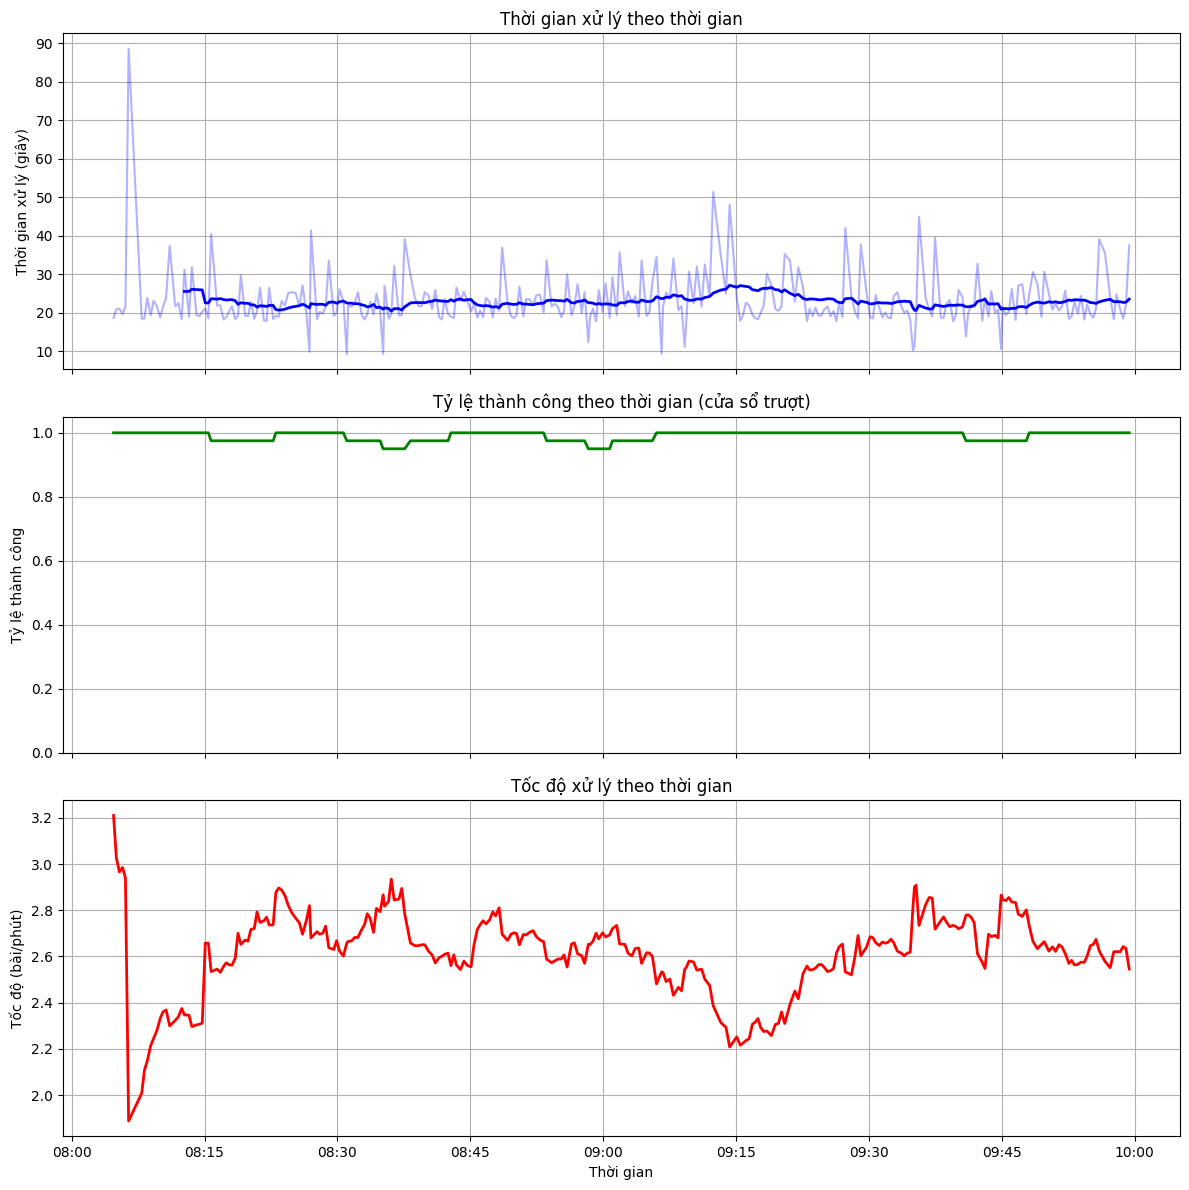


=== THỐNG KÊ TỔNG HỢP ===
Tổng số bài báo: 300
Thành công: 294 (98.0%)
Chưa hoàn chỉnh: 6 (2.0%)
Thất bại: 0 (0.0%)
Thời gian xử lý trung bình: 23.05 giây mỗi bài
Tổng thời gian xử lý: 115.25 phút
Tốc độ xử lý trung bình: 2.60 bài/phút

Ước tính thời gian để xử lý 13,000 bài còn lại: 81 giờ 19 phút


In [7]:
def visualize_performance_stats():
    """
    Hiển thị biểu đồ thống kê hiệu suất từ nhật ký xử lý.
    """
    try:
        # Đọc nhật ký xử lý
        if not PROCESSING_LOG_PATH.exists():
            print("Chưa có dữ liệu nhật ký xử lý. Hãy chạy pipeline trước.")
            return
            
        df_logs = pd.read_csv(PROCESSING_LOG_PATH)
        
        # Chuyển đổi cột thời gian
        for col in ['start_time', 'end_time']:
            if col in df_logs.columns:
                df_logs[col] = pd.to_datetime(df_logs[col])
        
        # Sắp xếp theo thời gian
        df_logs = df_logs.sort_values('start_time')
        
        # Tính toán các chỉ số hiệu suất
        df_logs['timestamp'] = df_logs['start_time']
        df_logs['processing_time'] = df_logs['duration_seconds']
        
        # Tạo cột thành công/thất bại
        df_logs['success'] = df_logs['processing_status'].apply(
            lambda x: 1 if x == 'SUCCESS' else (0.5 if x == 'INCOMPLETE' else 0)
        )
        
        # Tính tỷ lệ thành công theo thời gian (cửa sổ trượt)
        window_size = 20
        df_logs['success_rate'] = df_logs['success'].rolling(window=window_size, min_periods=1).mean()
        
        # Tính tốc độ xử lý (bài/phút) theo thời gian
        df_logs['processing_rate'] = 60 / df_logs['processing_time'].rolling(window=window_size, min_periods=1).mean()
        
        # Đảm bảo matplotlib được cài đặt
        try:
            import matplotlib.pyplot as plt
            from matplotlib.dates import DateFormatter
        except ImportError:
            print("Cài đặt thư viện matplotlib để hiển thị biểu đồ:")
            print("!pip install matplotlib")
            return
        
        # Tạo biểu đồ
        fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
        
        # 1. Biểu đồ thời gian xử lý
        axes[0].plot(df_logs['timestamp'], df_logs['processing_time'], 'b-', alpha=0.3)
        axes[0].plot(df_logs['timestamp'], df_logs['processing_time'].rolling(window=window_size).mean(), 'b-', linewidth=2)
        axes[0].set_ylabel('Thời gian xử lý (giây)')
        axes[0].set_title('Thời gian xử lý theo thời gian')
        axes[0].grid(True)
        
        # 2. Biểu đồ tỷ lệ thành công
        axes[1].plot(df_logs['timestamp'], df_logs['success_rate'], 'g-', linewidth=2)
        axes[1].set_ylabel('Tỷ lệ thành công')
        axes[1].set_title('Tỷ lệ thành công theo thời gian (cửa sổ trượt)')
        axes[1].set_ylim(0, 1.05)
        axes[1].grid(True)
        
        # 3. Biểu đồ tốc độ xử lý
        axes[2].plot(df_logs['timestamp'], df_logs['processing_rate'], 'r-', linewidth=2)
        axes[2].set_ylabel('Tốc độ (bài/phút)')
        axes[2].set_title('Tốc độ xử lý theo thời gian')
        axes[2].grid(True)
        
        # Định dạng trục x
        date_format = DateFormatter('%H:%M')
        axes[2].xaxis.set_major_formatter(date_format)
        plt.xlabel('Thời gian')
        
        # Hiển thị biểu đồ
        plt.tight_layout()
        plt.show()
        
        # Hiển thị thống kê tổng hợp
        total_papers = len(df_logs)
        success_count = len(df_logs[df_logs['processing_status'] == 'SUCCESS'])
        incomplete_count = len(df_logs[df_logs['processing_status'] == 'INCOMPLETE'])
        failed_count = len(df_logs[df_logs['processing_status'] == 'FAILED'])
        
        print("\n=== THỐNG KÊ TỔNG HỢP ===")
        print(f"Tổng số bài báo: {total_papers}")
        print(f"Thành công: {success_count} ({success_count/total_papers:.1%})")
        print(f"Chưa hoàn chỉnh: {incomplete_count} ({incomplete_count/total_papers:.1%})")
        print(f"Thất bại: {failed_count} ({failed_count/total_papers:.1%})")
        
        if 'duration_seconds' in df_logs.columns:
            avg_time = df_logs['duration_seconds'].mean()
            total_time = df_logs['duration_seconds'].sum() / 60  # phút
            
            print(f"Thời gian xử lý trung bình: {avg_time:.2f} giây mỗi bài")
            print(f"Tổng thời gian xử lý: {total_time:.2f} phút")
            print(f"Tốc độ xử lý trung bình: {total_papers/total_time:.2f} bài/phút")
            
            # Hiển thị ước tính thời gian cho toàn bộ bài báo còn lại
            remaining = 13000 - total_papers
            if remaining > 0:
                estimated_time = remaining / (total_papers/total_time)  # phút
                hours = estimated_time // 60
                minutes = estimated_time % 60
                print(f"\nƯớc tính thời gian để xử lý 13,000 bài còn lại: {int(hours)} giờ {int(minutes)} phút")
    
    except Exception as e:
        print(f"Lỗi khi tạo biểu đồ: {e}")
        import traceback
        traceback.print_exc()

# Gọi hàm để hiển thị biểu đồ (chạy sau khi pipeline đã xử lý ít nhất một batch)
visualize_performance_stats()

In [15]:
def check_processing_status():
    """
    Kiểm tra trạng thái xử lý hiện tại, tìm bài báo đã xử lý và bài báo chưa xử lý.
    Hàm này giúp bạn xác định tiến độ xử lý và điểm bắt đầu tiếp theo.
    """
    # Tải dữ liệu bài báo (tất cả bài báo, không lọc)
    df_all_papers = load_papers_data(start_from_index=None, start_from_id=None, skip_processed=False)
    
    if len(df_all_papers) == 0:
        print("Không tìm thấy bài báo nào. Kiểm tra thư mục input.")
        return
    
    # Lấy danh sách bài báo đã xử lý
    processed_papers = get_all_processed_papers()
    
    # Đánh dấu bài báo đã xử lý
    df_all_papers['processed'] = df_all_papers['paper_id'].isin(processed_papers)
    
    # Thống kê
    total_papers = len(df_all_papers)
    processed_count = df_all_papers['processed'].sum()
    remaining_count = total_papers - processed_count
    
    print(f"\n=== THỐNG KÊ TRẠNG THÁI XỬ LÝ ===")
    print(f"Tổng số bài báo: {total_papers}")
    print(f"Đã xử lý: {processed_count} ({processed_count/total_papers:.1%})")
    print(f"Chưa xử lý: {remaining_count} ({remaining_count/total_papers:.1%})")
    
    # Tìm paper_id đầu tiên chưa xử lý
    if remaining_count > 0:
        first_unprocessed = df_all_papers[~df_all_papers['processed']].iloc[0]
        first_unprocessed_id = first_unprocessed['paper_id']
        first_unprocessed_index = df_all_papers[~df_all_papers['processed']].index[0]
        
        print(f"\nBài báo đầu tiên chưa xử lý:")
        print(f"  - Vị trí: {first_unprocessed_index} (0-based index)")
        print(f"  - Paper ID: {first_unprocessed_id}")
        print(f"  - File nguồn: {first_unprocessed['source_file']}")
        
        print("\nĐể tiếp tục xử lý từ bài báo này, bạn có thể cấu hình:")
        print(f"  - START_FROM_PAPER_INDEX = {first_unprocessed_index}  # Bắt đầu từ vị trí")
        print(f"  - START_FROM_PAPER_ID = \"{first_unprocessed_id}\"  # Hoặc bắt đầu từ paper_id")
    else:
        print("\nĐã xử lý tất cả các bài báo!")

# Chạy để kiểm tra trạng thái xử lý hiện tại
check_processing_status()

2025-09-07 18:17:52,054 - INFO - Tìm thấy 8 file nguồn JSONL
2025-09-07 18:17:52,074 - INFO - Đã đọc file neurips_2021_conference.jsonl: 2630 bài báo
2025-09-07 18:17:52,079 - INFO - Đã đọc file neurips_2021_datasets_and_benchmarks.jsonl: 2804 bài báo
2025-09-07 18:17:52,074 - INFO - Đã đọc file neurips_2021_conference.jsonl: 2630 bài báo
2025-09-07 18:17:52,079 - INFO - Đã đọc file neurips_2021_datasets_and_benchmarks.jsonl: 2804 bài báo
2025-09-07 18:17:52,096 - INFO - Đã đọc file neurips_2022_conference.jsonl: 5475 bài báo
2025-09-07 18:17:52,098 - INFO - Đã đọc file neurips_2022_datasets_and_benchmarks.jsonl: 5637 bài báo
2025-09-07 18:17:52,117 - INFO - Đã đọc file neurips_2023_conference.jsonl: 8855 bài báo
2025-09-07 18:17:52,096 - INFO - Đã đọc file neurips_2022_conference.jsonl: 5475 bài báo
2025-09-07 18:17:52,098 - INFO - Đã đọc file neurips_2022_datasets_and_benchmarks.jsonl: 5637 bài báo
2025-09-07 18:17:52,117 - INFO - Đã đọc file neurips_2023_conference.jsonl: 8855 bài b


=== THỐNG KÊ TRẠNG THÁI XỬ LÝ ===
Tổng số bài báo: 13671
Đã xử lý: 349 (2.6%)
Chưa xử lý: 13322 (97.4%)

Bài báo đầu tiên chưa xử lý:
  - Vị trí: 302 (0-based index)
  - Paper ID: t0B9XQwRDi
  - File nguồn: neurips_2021_conference.jsonl

Để tiếp tục xử lý từ bài báo này, bạn có thể cấu hình:
  - START_FROM_PAPER_INDEX = 302  # Bắt đầu từ vị trí
  - START_FROM_PAPER_ID = "t0B9XQwRDi"  # Hoặc bắt đầu từ paper_id
